In [15]:
from sympy import Rational, factorial, zeros
from sympy.matrices import Matrix
import sympy as sp

def padee_approx(M, m):
    """
    Compute the mth degree Pade approximation for e^M.
    
    Parameters:
    M : matrix or scalar
        The input matrix or scalar for which to compute the exponential.
    m : int
        The degree of the Pade approximation.
        
    Returns:
    Matrix or scalar
        The Pade approximation of e^M.
    """
    # Numerator Coefficients
    def B_coef(k):
        return Rational(
            factorial(2*m - k) * factorial(m),
            factorial(2*m) * factorial(k) * factorial(m - k)
        )
    
    # Denominator Coefficients    
    def A_coef(k): 
        return (-1)**k * B_coef(k)  
    
    # Check if M is a matrix by verifying if it has the 'shape' attribute
    if hasattr(M, 'shape'):
        # M is assumed to be a matrix
        rows, cols = M.shape
        N = zeros(rows, cols)
        D = zeros(rows, cols)
    
        for k in range(0, m + 1):
            N += B_coef(k) * M**k
            D += A_coef(k) * M**k
        
        # Return the matrix product of N and the inverse of D
        return N * D.inv()
    else:
        # M is assumed to be a scalar
        N = 0
        D = 0
        for k in range(0, m + 1):
            N += B_coef(k) * M**k
            D += A_coef(k) * M**k
        
        # Return the scalar division of N by D
        return N / D


In [16]:
import sympy as sp
import numpy as np

def compute_s(M, theta):
    """
    Compute the scaling factor 's' based on the infinity norm of matrix M and threshold theta.

    Parameters:
        M (sp.Matrix): The input matrix.
        theta (float): The threshold value.

    Returns:
        int: The scaling factor 's'.
    """
    norm = np.abs(M.norm(ord=sp.oo))
    s = sp.ceiling(sp.log(norm / theta, 2))
    s = max(s, 0)  # Ensure s is not negative. YOU may be able to get rid of this by ensuring the norm is never less than the theta. 
    return s

def scale_matrix(M, theta):
    """
    Scale the matrix M by 2^s, where s is determined based on theta.

    Parameters:
        M (sp.Matrix): The input matrix.
        theta (float): The threshold value.

    Returns:
        tuple: A tuple containing the scaled matrix B and the scaling factor s.
    """
    s = compute_s(M, theta)
    B = M / (2 ** s)
    return B, s

def padee_and_scale(M, theta_for_m_3):
    """
    Apply Pade approximation to matrix M, scaling it if necessary based on theta_for_m_3.

    Parameters:
        M (array-like): The input matrix.
        theta_for_m_3 (float): The threshold value for deciding scaling.

    Returns:
        sp.Matrix: The resulting matrix after Pade approximation and scaling.
    """
    # Ensure M is a SymPy Matrix with complex entries
    M = sp.Matrix(M).applyfunc(lambda x: sp.nsimplify(x, rational=True))  # Convert to SymPy types

    # Compute the infinity norm of M
    norm_inf = M.norm(ord=sp.oo)

    if norm_inf < theta_for_m_3:
        return padee_approx(M, 3)

    # Scale the matrix if norm_inf >= theta_for_m_3
    B, s = scale_matrix(M, theta_for_m_3)

    # Apply Pade approximation to the scaled matrix
    B = padee_approx(B, 3)

    # Rescale the result
    B = B ** (2 ** s)

    return B


In [17]:
display( sp.simplify(padee_approx(sp.symbols('B'),3))) 
# Only do odd numbers, even numbers introduce poles or something that make them less accurate.

(-B**3 - 12*B**2 - 60*B - 120)/(B**3 - 12*B**2 + 60*B - 120)

Max bits needed is: 36.0


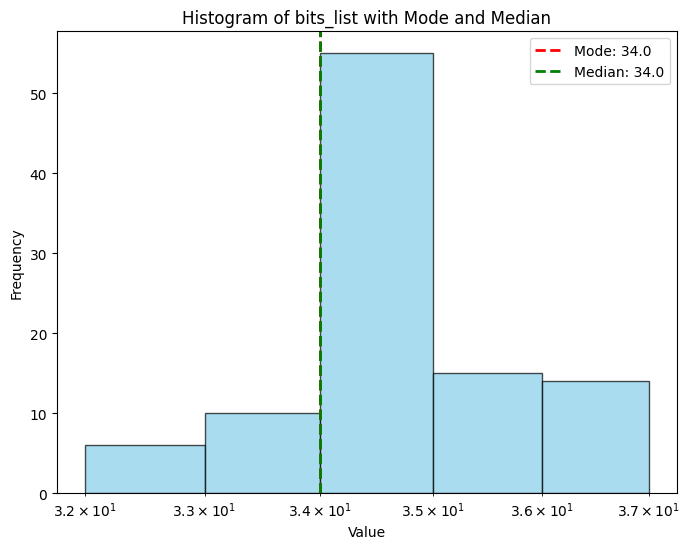

13

In [18]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from statistics import median, mode
B = sp.symbols('B')
num, den = sp.fraction(sp.simplify(padee_approx(B,3)))
num = sp.simplify(num)
den = sp.simplify(den)

num_poly = sp.Poly(num, B)
den_poly = sp.Poly(den, B)

bits_list = []
for i in range(0,100):

    #sp.pprint(num_poly)

    def eval_poly_matrix(poly, M):
        # Get the coefficients in order of descending degree.
        coeffs = poly.all_coeffs()  # e.g., [a_n, a_{n-1}, ..., a_0]
        deg = len(coeffs) - 1
        # Initialize the result as a zero matrix of the same size as M.
        result = sp.zeros(M.rows, M.cols)
        for i, coeff in enumerate(coeffs):
            power = deg - i
            result += coeff * (M ** power)
        return result

    M = sp.Matrix(np.ceil( 10 * np.random.rand(4,4)  ))

    result_matrix = eval_poly_matrix(num_poly, M)
    #sp.pprint(result_matrix)

    max_norm = max(abs(val) for val in result_matrix)

    #sp.pprint(max_norm)

    integer_bits = sp.ceiling(sp.log(max_norm, 2).evalf(3))

    #sp.pprint(integer_bits)

    decimal_bits = compute_s(result_matrix, 1.495585217958292 * 10**-2  )
    #sp.pprint(decimal_bits)
    
    bits_list.append(decimal_bits + integer_bits)

#sp.pprint(bits_list)


bits_list_numeric = [float(val) for val in bits_list]

# Compute the median and mode.
median_value = median(bits_list_numeric)
mode_value = mode(bits_list_numeric)

# Determine the bin edges so that each bin represents an integer.
min_val = min(bits_list_numeric)
max_val = max(bits_list_numeric)
print(f"Max bits needed is: {max_val}" )
bins = np.arange(min_val, max_val + 2)  # +2 so that the last bin edge includes max_val

# Create the histogram.
plt.figure(figsize=(8, 6))
plt.hist(bits_list_numeric, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')

# Plot vertical lines for mode and median.
plt.axvline(mode_value, color='red', linestyle='dashed', linewidth=2, label=f'Mode: {mode_value}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value}')

# Add labels and title.
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xscale('log')
plt.title('Histogram of bits_list with Mode and Median')
plt.legend()

plt.show()


compute_s( 8192j * sp.Matrix([[1, 1j],[0,1]]), 2.1)

In [19]:
theta_for_m_3 = 1.495585217958292 * 10**-2 
theta_for_m_5 = 2.539398330063230 * 10**-1

In [20]:
from numba import jit
import numpy as np


testMatrix = Matrix([[1+3*sp.I,0.2+0.4*sp.I],[-4-4*sp.I,-0.8*sp.I]])

display("The inputted matrix:", testMatrix)

print("The matrices norm is", testMatrix.norm(sp.oo).evalf(3))

display("In-built function exp():", testMatrix.exp().evalf(3))

display("My function:", padee_and_scale(testMatrix, theta_for_m_3).evalf(3))





'The inputted matrix:'

Matrix([
[ 1 + 3*I, 0.2 + 0.4*I],
[-4 - 4*I,      -0.8*I]])

The matrices norm is 6.46


'In-built function exp():'

Matrix([
[-1.17 + 1.33*I, -0.235 + 0.397*I],
[ 1.23 - 5.71*I,    1.57 - 1.67*I]])

'My function:'

Matrix([
[-1.17 + 1.33*I, -0.235 + 0.397*I],
[ 1.23 - 5.71*I,    1.57 - 1.67*I]])

# So the pipeline for this is gonna look like this:

1. We spilt the Hamilation Matrix into 6 matrices, one associasted with each cell so we have empty matrices except for one cell. This minimizes their norm  and allows for much easier matrix multiplication and squaring so computation is easier. (Here H1 H2 etc mean the six matrices that add up to H)
    $$e^H = e^{H_1}e^{H_2}e^{H_3}e^{H_4}e^{H_5}e^{H_6}$$
2. In VHDL we take the symbolic equations for each Matrices cell and use them to calculate a concrete value (example from one of the matrices):
    $$-it(-H1+H2-J) = C$$
3. We take this matrix with one cell that is the value C and if the matrices norm exceeds $1.496* 10^{-2}$ we calculate our scaling factor s, if not we simply use it directly with Padee approximation. 
    $$
    s = \left\lceil \log_2\left(\frac{\|A\|}{\theta}\right) \right\rceil , \theta=1.496* 10^{-2}
    $$
4. If we have a scaling factor $s$ we divide the matrix with value $C$ by the value $2^s$ to get a new scaled down matrix.
$$B = \frac{H_n}{2^{s}} = \frac{C}{2^{s}} $$
5. We use this scaled down matrix B in our third degree Pradee approximattion. 
$$\frac{- B^{3} - 12 B^{2} - 60 B - 120}{B^{3} - 12 B^{2} + 60 C - 120} = B_n$$
6. We take this matrix $B_n$ and scale it back up through the following formula:
$$B_f = B_n^{2^{s}}$$
7. $Bf$ is our final result. We do this $H_1$ through $H_6$ and then multiply all six together to get our final result $e^H$



In [33]:
import numpy as np

def evaluate_numerator(B):
    """
    Evaluates the numerator polynomial: -B³ -12B² -60B -120
    for a square matrix B using Horner's nested form.
    """
    I = np.eye(B.shape[0])  # Identity matrix
    term = B + 12 * I       # (B + 12I)
    term = term @ B + 60 * I  # ((B + 12I)B + 60I)
    term = term @ B + 120 * I # (((B + 12I)B + 60I)B + 120I)
    return -term             # Negative of the result

def evaluate_denominator(B):
    """
    Evaluates the denominator polynomial: B³ -12B² +60B -120
    for a square matrix B using Horner's nested form.
    """
    I = np.eye(B.shape[0])  # Identity matrix
    term = B - 12 * I       # (B - 12I)
    term = term @ B + 60 * I  # ((B - 12I)B + 60I)
    term = term @ B - 120 * I # (((B - 12I)B + 60I)B - 120I)
    return term


def process_matrix(A, t):
    """
    Process the matrix A with time parameter t and return the number of bits needed.
    
    Steps:
      1. Multiply A by t * 1j (imaginary unit) to obtain a complex matrix.
      2. Compute a scaling factor S using compute_s and theta_for_m_3.
      3. Downscale the complex matrix by 2^(-S).
      4. Evaluate the denominator polynomial on the downscaled matrix.
      5. Compute the product of the 1-norm (max column sum) and infinity norm (max row sum)
         of the resulting matrix.
      6. Return the number of bits needed as ceil(log2(norm_product)).
    
    Parameters:
        A (np.ndarray): Input square matrix.
        t (float): Time parameter.
        
    Returns:
        float: The number of bits needed.
    """
    # Nested helper function to compute product of norms.
    def product_norms(matrix):
        norm_1 = np.max(np.sum(np.abs(matrix), axis=0))
        norm_inf = np.max(np.sum(np.abs(matrix), axis=1))
        return norm_1 * norm_inf
    
    # Step 1: Scale the matrix by t * 1j.
    A_complex = t * 1j * A
    
    # Step 2: Compute scaling factor S using compute_s and theta_for_m_3.
    # (Ensure compute_s and theta_for_m_3 are defined in your notebook.)
    S = compute_s(sp.Matrix(A_complex), theta_for_m_3)
    
    # Step 3: Downscale the matrix.
    downscaled_A = A_complex * 2**(-S)
    
    # Step 4: Evaluate the denominator polynomial.
    denominator = evaluate_denominator(downscaled_A)
    
    # Step 5: Compute the product of the norms.
    norm_product = np.float64(product_norms(denominator))
    
    # Step 6: Compute and return the number of bits needed.
    
    return norm_product



import pickle

# Open the pickle file and load the Hamiltonians into the variable HAM
with open("HAM.pkl", "rb") as f:
    HAM = pickle.load(f)

N1N2_list = []
for A in HAM:
    for t in np.linspace(0.01,2*np.pi,1000):
        N1N2_list.append(process_matrix(A,np.float64(t)))

print(f"The Range of N1*N2 products for a the above matrix is:\n [{np.floor(min(N1N2_list))} : {np.ceil((max(N1N2_list)))} ] with a difference of {np.ceil(max(N1N2_list) - min(N1N2_list))}")









The Range of N1*N2 products for a the above matrix is:
 [14400.0 : 14508.0 ] with a difference of 108.0
